In [1]:
import numpy as np
import pandas as pd
import os

In [8]:
train = pd.read_csv('data/amazon-employee-access-challenge/train.csv')
test = pd.read_csv('data/amazon-employee-access-challenge/test.csv')

In [9]:
print(train.shape)
print(test.shape)

(32769, 10)
(58921, 10)


In [10]:
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [11]:
test.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [13]:
print(train.isnull().sum())

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64


In [14]:
# Counting unique values of categorical variables
train.apply(lambda x: len(x.unique()))

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

In [ ]:
# RESOURCE | MGR_ID ROLE_FAMILY_DESC  => high-cardinality categorical features
# ROLE_TITLE | ROLE_CODE = > the same amount of unique values

 https://wikidocs.net/46758 
### apply() 함수
Dataframe의 칼럼에 복잡한 연산을 vetorizing 할 수 있게 해주는 함수


특정함수를 적용시킴

### lambda() 함수
    lambda <매개변수1>, <매개변수2> .. : 매개변수를 이용한 식

### apply()함수와 lambda()함수 연결


    dataframe.apply(lambda x : x['칼럼명']들의 조건식)                              

In [22]:
import itertools
target = "ACTION"
col4train = [x for x in train.columns if x!=target]

col1 = 'ROLE_CODE'
col2 = 'ROLE_TITLE'

pair = len(train.groupby([col1, col2]).size())
single = len(train.groupby([col1]).size())

print(col1, col2, pair, single)

ROLE_CODE ROLE_TITLE 343 343


In [18]:
# ROLETITLE 컬럼명 제거
col4train = [x for x in col4train if x!='ROLETITLE']

In [21]:
# One-hot encoding 적용
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=True, dtype=np.float32, handle_unknown='ignore')

In [24]:
X = ohe.fit_transform(train[col4train])
y = train["ACTION"].values

In [31]:
# 선형회귀 적용 후 교차검증
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

model = LogisticRegression(
                penalty = 'l2',
                C = 1.0,
                fit_intercept = True,
                solver = 'liblinear',
                max_iter = 1000,
)

stats = cross_validate(model, X, y, groups=None, scoring='roc_auc', 
                      cv = 5, n_jobs=2, return_train_score = True)
stats = pd.DataFrame(stats)
stats.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,0.525299,0.073298,0.396773,0.536692,0.553680,0.562681,0.576669
score_time,5.0,0.005396,0.002301,0.002998,0.003993,0.004998,0.005998,0.008995
test_score,5.0,0.863074,0.009796,0.851246,0.853877,0.867258,0.871329,0.871660
train_score,5.0,0.974452,0.000725,0.973388,0.974255,0.974386,0.974957,0.975272


In [33]:
# baseline에 대한 점수 확인
X = ohe.fit_transform(train[col4train])
y = train['ACTION'].values
X_te = ohe.transform(test[col4train])

model.fit(X,y)
predictions = model.predict_proba(X_te)[:,1]

submit = pd.DataFrame()
submit["id"] = test["id"]
submit["ACTION"] = predictions

submit.to_csv("data/amazon-employee-access-challenge/submission.csv", index = False)

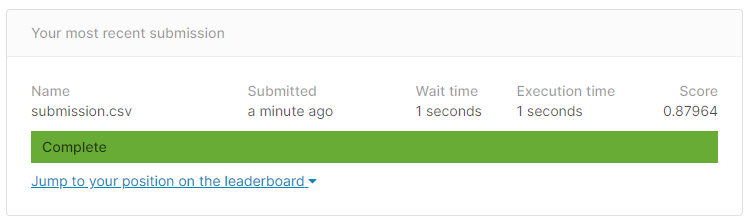